In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random

In [3]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Some Classification

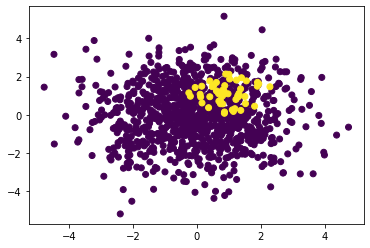

In [225]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [1.0, 1.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

In [4]:
input_size = 2
hidden_size = 12
output_size = 2

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [5]:
epochs = 10000
learning_rate = 0.01

## TERM/Entropic Risk

In [29]:
class EntropicRisk(nn.Module):
    def __init__(self, t=10, criterion=nn.CrossEntropyLoss(reduction='none')):
        super().__init__()
        self.t = t
        self.criterion = criterion
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        # t = 0 should return ERM
        if self.t == 0:
            return torch.mean(loss)
        
        return (1 / self.t) * torch.log(torch.mean(torch.exp(self.t * loss)))

In [229]:
# class EntropicRisk(nn.Module):
#     def __init__(self, t=10, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='none'):
#         super().__init__()
#         self.t = t
#         self.criterion = criterion
#         self.reduction = reduction
    
#     def forward(self, output, labels):
#         loss = self.criterion(output, labels)
#         s# t = 0 should return ERM
#         if self.t == 0:
#             if self.reduction == 'mean':
#                 return torch.mean(loss)
#             elif self.reduction == 'sum':
#                 return torch.sum(loss)
#             return loss
            
#         tilt = torch.exp(self.t * loss)
        
#         if self.reduction == 'mean':
#             return (1 / self.t) * torch.log(torch.mean(tilt))
#         elif self.reduction == 'sum':
#             return (1 / self.t) * torch.log(torch.sum(tilt))
#         return (1 / self.t) * torch.log(tilt)

1.9545141458511353
0.5319837927818298
0.527167022228241
0.5245843529701233
0.5231561064720154
0.5216724872589111
0.5203251242637634
0.5179837942123413
0.5150042176246643
0.5136303305625916
Final loss:  0.5126691460609436


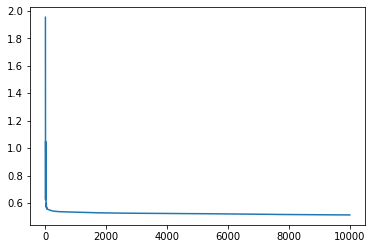

In [238]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = EntropicRisk(t=10)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

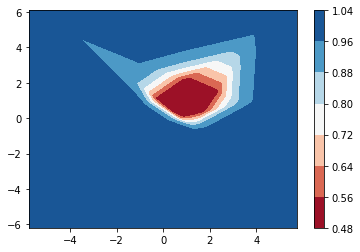

In [239]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

## ERM

0.949751615524292
0.1250734031200409
0.12057312577962875
0.11815382540225983
0.11685791611671448
0.11605340242385864
0.11568409949541092
0.11541594564914703
0.115211620926857
0.11502785235643387
Final loss:  0.11485955864191055


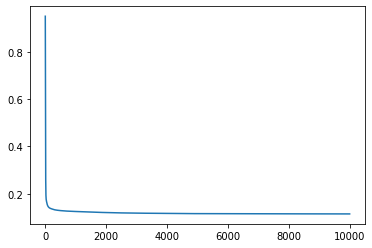

In [172]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = nn.CrossEntropyLoss()
model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

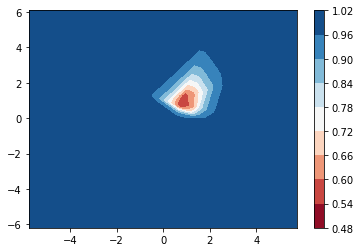

In [173]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# Linear Regression

In [174]:
# Taken from TERM Github: https://github.com/litian96/TERM/blob/master/toy_example/linear-regression.ipynb

def abline(a, b, label_, c=None):
    
    """Plot a line from slope and intercept"""
    axes = plt.gca()
#     x_vals = np.array(axes.get_xlim())
    x_vals = np.arange(-3, 3, 0.1)
    y_vals = a * x_vals + b
    plt.plot(x_vals, y_vals, label=label_, color=c, zorder=1)

In [175]:
num_sample = 290
num_outlier = 10
total_samples = num_sample + num_outlier

theta = [-1, 0.2]
#X = np.random.random_sample(num_sample) * 0.5 
X = np.random.normal(0, 0.5, num_sample)
y = theta[0]*X + theta[1] 

y += np.random.normal(0, 0.1, num_sample)

X_out = np.random.normal(-2, 0.5, num_outlier)
y_out = np.random.normal(0, 0.5, num_outlier)

y = np.append(y, y_out)
X = np.append(X, X_out)

print(X.shape, y.shape)

(300,) (300,)


In [176]:
inputs = torch.tensor(X.reshape((-1, 1)), dtype=torch.float32)
labels = torch.tensor(y.reshape((-1, 1)), dtype=torch.float32)

In [177]:
class SimpleLinearRegression(torch.nn.Module):
    def __init__(self):
        super(SimpleLinearRegression, self).__init__()
        self.linear = nn.Linear(1, 1)
    
    def forward(self, x):
        return self.linear(x)

Tilt: -1.0 Epoch: 0 Tilt Loss: 0.4381994307041168 MSE Loss: 0.5144959092140198
Tilt: -1.0 Epoch: 100 Tilt Loss: 0.15966567397117615 MSE Loss: 0.18925198912620544
Tilt: -1.0 Epoch: 200 Tilt Loss: 0.09049374610185623 MSE Loss: 0.12350790947675705
Tilt: -1.0 Epoch: 300 Tilt Loss: 0.0687471553683281 MSE Loss: 0.11431191861629486
Tilt: -1.0 Epoch: 400 Tilt Loss: 0.05806752294301987 MSE Loss: 0.11658021062612534
Tilt: -1.0 Epoch: 500 Tilt Loss: 0.051363203674554825 MSE Loss: 0.1216697171330452
Tilt: -1.0 Epoch: 600 Tilt Loss: 0.0469118133187294 MSE Loss: 0.12755186855793
Tilt: -1.0 Epoch: 700 Tilt Loss: 0.043968312442302704 MSE Loss: 0.13345085084438324
Tilt: -1.0 Epoch: 800 Tilt Loss: 0.04204876348376274 MSE Loss: 0.13896140456199646
Tilt: -1.0 Epoch: 900 Tilt Loss: 0.04081158712506294 MSE Loss: 0.1438797563314438
Tilt: -1.0 Epoch: 1000 Tilt Loss: 0.04002121463418007 MSE Loss: 0.14813314378261566
Tilt: -1.0 Epoch: 1100 Tilt Loss: 0.03951951116323471 MSE Loss: 0.1517297774553299
Tilt: -1.0 E

Tilt: -1.0 Epoch: 9800 Tilt Loss: 0.038664545863866806 MSE Loss: 0.16721941530704498
Tilt: -1.0 Epoch: 9900 Tilt Loss: 0.038664545863866806 MSE Loss: 0.16721941530704498
Tilt: -1.0 Epoch: 9999 Final loss:  0.038664545863866806 

tensor([[-0.9786]]) tensor([0.1923])
Tilt: -0.9 Epoch: 0 Tilt Loss: 0.4446631669998169 MSE Loss: 0.5144959092140198
Tilt: -0.9 Epoch: 100 Tilt Loss: 0.1596536487340927 MSE Loss: 0.18689055740833282
Tilt: -0.9 Epoch: 200 Tilt Loss: 0.0912947729229927 MSE Loss: 0.12288641929626465
Tilt: -0.9 Epoch: 300 Tilt Loss: 0.07039601355791092 MSE Loss: 0.11429955810308456
Tilt: -0.9 Epoch: 400 Tilt Loss: 0.06021735444664955 MSE Loss: 0.11660639196634293
Tilt: -0.9 Epoch: 500 Tilt Loss: 0.05381707847118378 MSE Loss: 0.12156137824058533
Tilt: -0.9 Epoch: 600 Tilt Loss: 0.04954926669597626 MSE Loss: 0.12726858258247375
Tilt: -0.9 Epoch: 700 Tilt Loss: 0.04671235382556915 MSE Loss: 0.13299912214279175
Tilt: -0.9 Epoch: 800 Tilt Loss: 0.04485113546252251 MSE Loss: 0.13836593925

Tilt: -0.9 Epoch: 9700 Tilt Loss: 0.041516292840242386 MSE Loss: 0.16632257401943207
Tilt: -0.9 Epoch: 9800 Tilt Loss: 0.041516292840242386 MSE Loss: 0.16632257401943207
Tilt: -0.9 Epoch: 9900 Tilt Loss: 0.041516292840242386 MSE Loss: 0.16632257401943207
Tilt: -0.9 Epoch: 9999 Final loss:  0.041516292840242386 

tensor([[-0.9755]]) tensor([0.1919])
Tilt: -0.8 Epoch: 0 Tilt Loss: 0.45134130120277405 MSE Loss: 0.5144959092140198
Tilt: -0.8 Epoch: 100 Tilt Loss: 0.1597379446029663 MSE Loss: 0.18457554280757904
Tilt: -0.8 Epoch: 200 Tilt Loss: 0.09238941967487335 MSE Loss: 0.12233363837003708
Tilt: -0.8 Epoch: 300 Tilt Loss: 0.07245238870382309 MSE Loss: 0.11429368704557419
Tilt: -0.8 Epoch: 400 Tilt Loss: 0.06285466998815536 MSE Loss: 0.11656352877616882
Tilt: -0.8 Epoch: 500 Tilt Loss: 0.05681354179978371 MSE Loss: 0.1213051974773407
Tilt: -0.8 Epoch: 600 Tilt Loss: 0.052764248102903366 MSE Loss: 0.12676210701465607
Tilt: -0.8 Epoch: 700 Tilt Loss: 0.05005326867103577 MSE Loss: 0.1322583

Tilt: -0.8 Epoch: 9500 Tilt Loss: 0.04497285559773445 MSE Loss: 0.16501803696155548
Tilt: -0.8 Epoch: 9600 Tilt Loss: 0.04497285559773445 MSE Loss: 0.16501803696155548
Tilt: -0.8 Epoch: 9700 Tilt Loss: 0.04497285559773445 MSE Loss: 0.16501803696155548
Tilt: -0.8 Epoch: 9800 Tilt Loss: 0.04497285559773445 MSE Loss: 0.16501803696155548
Tilt: -0.8 Epoch: 9900 Tilt Loss: 0.04497285559773445 MSE Loss: 0.16501803696155548
Tilt: -0.8 Epoch: 9999 Final loss:  0.04497285559773445 

tensor([[-0.9710]]) tensor([0.1914])
Tilt: -0.7000000000000001 Epoch: 0 Tilt Loss: 0.4582480490207672 MSE Loss: 0.5144959092140198
Tilt: -0.7000000000000001 Epoch: 100 Tilt Loss: 0.15994806587696075 MSE Loss: 0.18231596052646637
Tilt: -0.7000000000000001 Epoch: 200 Tilt Loss: 0.09384132921695709 MSE Loss: 0.12185613065958023
Tilt: -0.7000000000000001 Epoch: 300 Tilt Loss: 0.07500465959310532 MSE Loss: 0.11429115384817123
Tilt: -0.7000000000000001 Epoch: 400 Tilt Loss: 0.066090427339077 MSE Loss: 0.1164330542087555
Ti

Tilt: -0.7000000000000001 Epoch: 8000 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8100 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8200 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8300 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8400 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8500 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8600 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8700 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8800 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342
Tilt: -0.7000000000000001 Epoch: 8900 Tilt Loss: 0.049226291477680206 MSE Loss: 0.16305053234100342


Tilt: -0.6000000000000001 Epoch: 7900 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8000 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8100 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8200 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8300 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8400 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8500 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8600 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8700 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6000000000000001 Epoch: 8800 Tilt Loss: 0.05453960970044136 MSE Loss: 0.15997831523418427
Tilt: -0.6

Tilt: -0.5000000000000001 Epoch: 6200 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6300 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6400 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6500 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6600 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6700 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6800 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 6900 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 7000 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.5000000000000001 Epoch: 7100 Tilt Loss: 0.06125364452600479 MSE Loss: 0.1550503820180893
Tilt: -0.50000000000

Tilt: -0.40000000000000013 Epoch: 6100 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 6200 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 6300 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 6400 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 6500 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 6600 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 6700 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 6800 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 6900 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802
Tilt: -0.40000000000000013 Epoch: 7000 Tilt Loss: 0.06973285973072052 MSE Loss: 0.14717121422290802


Tilt: -0.30000000000000016 Epoch: 5600 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 5700 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 5800 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 5900 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 6000 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 6100 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 6200 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 6300 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 6400 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.30000000000000016 Epoch: 6500 Tilt Loss: 0.08010424673557281 MSE Loss: 0.1357519030570984
Tilt: -0.3

Tilt: -0.20000000000000018 Epoch: 5500 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 5600 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 5700 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 5800 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 5900 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 6000 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 6100 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 6200 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 6300 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043
Tilt: -0.20000000000000018 Epoch: 6400 Tilt Loss: 0.09173043072223663 MSE Loss: 0.12364649772644043


Tilt: -0.1000000000000002 Epoch: 3700 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 3800 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 3900 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 4000 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 4100 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 4200 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 4300 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 4400 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 4500 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1000000000000002 Epoch: 4600 Tilt Loss: 0.10335385799407959 MSE Loss: 0.11622191220521927
Tilt: -0.1

Tilt: -2.220446049250313e-16 Epoch: 3900 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4000 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4100 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4200 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4300 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4400 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4500 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4600 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4700 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4800 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 4900 Tilt Loss: -0.0 MSE Loss: 0.11423499137163162
Tilt: -2.220446049250313e-16 Epoch: 5000 Ti

Tilt: 0.09999999999999964 Epoch: 3900 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4000 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4100 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4200 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4300 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4400 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4500 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4600 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4700 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoch: 4800 Tilt Loss: 0.12432339787483215 MSE Loss: 0.115505151450634
Tilt: 0.09999999999999964 Epoc

Tilt: 0.19999999999999973 Epoch: 3800 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 3900 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 4000 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 4100 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 4200 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 4300 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 4400 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 4500 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 4600 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoch: 4700 Tilt Loss: 0.133788600564003 MSE Loss: 0.11836850643157959
Tilt: 0.19999999999999973 Epoc

Tilt: 0.2999999999999998 Epoch: 3700 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 3800 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 3900 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 4000 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 4100 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 4200 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 4300 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 4400 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 4500 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.2999999999999998 Epoch: 4600 Tilt Loss: 0.14280655980110168 MSE Loss: 0.12194313108921051
Tilt: 0.299999999999

Tilt: 0.3999999999999997 Epoch: 3700 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 3800 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 3900 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 4000 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 4100 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 4200 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 4300 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 4400 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 4500 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch: 4600 Tilt Loss: 0.15151584148406982 MSE Loss: 0.1257733702659607
Tilt: 0.3999999999999997 Epoch

Tilt: 0.49999999999999956 Epoch: 3600 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 3700 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 3800 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 3900 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 4000 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 4100 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 4200 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 4300 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 4400 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49999999999999956 Epoch: 4500 Tilt Loss: 0.16003112494945526 MSE Loss: 0.12961721420288086
Tilt: 0.49

Tilt: 0.5999999999999996 Epoch: 3400 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 3500 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 3600 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 3700 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 3800 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 3900 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 4000 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 4100 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 4200 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.5999999999999996 Epoch: 4300 Tilt Loss: 0.16844573616981506 MSE Loss: 0.13334141671657562
Tilt: 0.599999999999

Tilt: 0.6999999999999997 Epoch: 3400 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 3500 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 3600 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 3700 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 3800 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 3900 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 4000 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 4100 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 4200 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.6999999999999997 Epoch: 4300 Tilt Loss: 0.17684052884578705 MSE Loss: 0.13687187433242798
Tilt: 0.699999999999

Tilt: 0.7999999999999996 Epoch: 3300 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 3400 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 3500 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 3600 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 3700 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 3800 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 3900 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 4000 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 4100 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 4200 Tilt Loss: 0.1852887123823166 MSE Loss: 0.1401684731245041
Tilt: 0.7999999999999996 Epoch: 4300 Til

Tilt: 0.8999999999999995 Epoch: 3200 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 3300 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 3400 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 3500 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 3600 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 3700 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 3800 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 3900 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 4000 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.8999999999999995 Epoch: 4100 Tilt Loss: 0.19385893642902374 MSE Loss: 0.14321166276931763
Tilt: 0.899999999999

Tilt: 0 Epoch: 3900 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4000 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4100 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4200 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4300 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4400 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4500 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4600 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4700 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4800 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 4900 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 5000 Tilt Loss: 0.11423499137163162 MSE Loss: 0.11423499137163162
Tilt: 0 Epoch: 5100 Tilt Los

Tilt: 1 Epoch: 5200 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 5300 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 5400 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 5500 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 5600 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 5700 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 5800 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 5900 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 6000 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 6100 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 6200 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 6300 Tilt Loss: 0.20261597633361816 MSE Loss: 0.14599473774433136
Tilt: 1 Epoch: 6400 Tilt Los

Tilt: 2 Epoch: 7100 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 7200 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 7300 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 7400 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 7500 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 7600 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 7700 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 7800 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 7900 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 8000 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 8100 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 8200 Tilt Loss: 0.3137553036212921 MSE Loss: 0.16165265440940857
Tilt: 2 Epoch: 8300 Tilt Loss: 0.3137553

Tilt: 3 Epoch: 8700 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 8800 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 8900 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9000 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9100 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9200 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9300 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9400 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9500 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9600 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9700 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9800 Tilt Loss: 0.4913141131401062 MSE Loss: 0.1667979508638382
Tilt: 3 Epoch: 9900 Tilt Loss: 0.4913141131401062 MS

Tilt: 5 Epoch: 800 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18324948847293854
Tilt: 5 Epoch: 900 Tilt Loss: 0.8752507567405701 MSE Loss: 0.18332338333129883
Tilt: 5 Epoch: 1000 Tilt Loss: 0.8752507567405701 MSE Loss: 0.18333400785923004
Tilt: 5 Epoch: 1100 Tilt Loss: 0.8752509355545044 MSE Loss: 0.1833355724811554
Tilt: 5 Epoch: 1200 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 1300 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 1400 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 1500 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 1600 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 1700 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 1800 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 1900 Tilt Loss: 0.8752509355545044 MSE Loss: 0.18333561718463898
Tilt: 5 Epoch: 2000 Tilt Loss: 0.8752509355

Tilt: 6 Epoch: 1000 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158512353897095
Tilt: 6 Epoch: 1100 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 1200 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 1300 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 1400 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 1500 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 1600 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 1700 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 1800 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 1900 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 2000 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 2100 Tilt Loss: 1.0084686279296875 MSE Loss: 0.19158583879470825
Tilt: 6 Epoch: 2200 Tilt Loss: 1.0084686

Tilt: 7 Epoch: 3000 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3100 Tilt Loss: 1.1085278987884521 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3200 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3300 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3400 Tilt Loss: 1.1085278987884521 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3500 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3600 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3700 Tilt Loss: 1.1085278987884521 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3800 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 3900 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 4000 Tilt Loss: 1.1085278987884521 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 4100 Tilt Loss: 1.108527660369873 MSE Loss: 0.19789808988571167
Tilt: 7 Epoch: 4200 Tilt Loss: 1.108527660369873

Tilt: 8 Epoch: 5000 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5100 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5200 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5300 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5400 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5500 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5600 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5700 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5800 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 5900 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 6000 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 6100 Tilt Loss: 1.1854727268218994 MSE Loss: 0.20264114439487457
Tilt: 8 Epoch: 6200 Tilt Loss: 1.1854727

Tilt: 9 Epoch: 7200 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 7300 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 7400 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 7500 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 7600 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 7700 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 7800 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 7900 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 8000 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 8100 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 8200 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 8300 Tilt Loss: 1.2462390661239624 MSE Loss: 0.2062576860189438
Tilt: 9 Epoch: 8400 Tilt Loss: 1.2462390661239624 MS

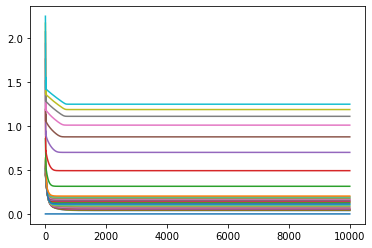

In [178]:
epochs = 10000

tilts = [i for i in np.arange(-1, 1, 0.1)] + [i for i in np.arange(0, 10, 1)]
weights = []
biases = []
final_losses = []

for t in tilts:
    # Reset random seeds for comparaison.
    SEED = 15
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

    criterion = EntropicRisk(t=t, criterion=nn.MSELoss(reduction='none'))
    mse_criterion = nn.MSELoss()

    model = SimpleLinearRegression()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.8)
    losses = []

    for epoch in range(epochs):
        # clear the gradients so they wont accumulate
        optimizer.zero_grad()

        output = model(inputs)

        # negative likelihood (expected risk)
        loss = criterion(output, labels)
        mse_loss = mse_criterion(output, labels)
        losses.append(loss.item())

        if epoch % 100 == 0:
            print('Tilt:', t, 'Epoch:', epoch, 'Tilt Loss:', loss.item(), 'MSE Loss:', mse_loss.item())

        # calculate gradient
        loss.backward()

        # gradient descent
        optimizer.step()

    print('Tilt:', t, 'Epoch:', epoch, 'Final loss: ', losses[-1], '\n')
    
    [w, b] = model.parameters()
    print(w.data, b.data)
    w1, b1 = w.data[0][0], b.data[0]
    
    weights.append(w1)
    biases.append(b1)
    final_losses.append(losses[-1])
    
    plt.plot(losses)

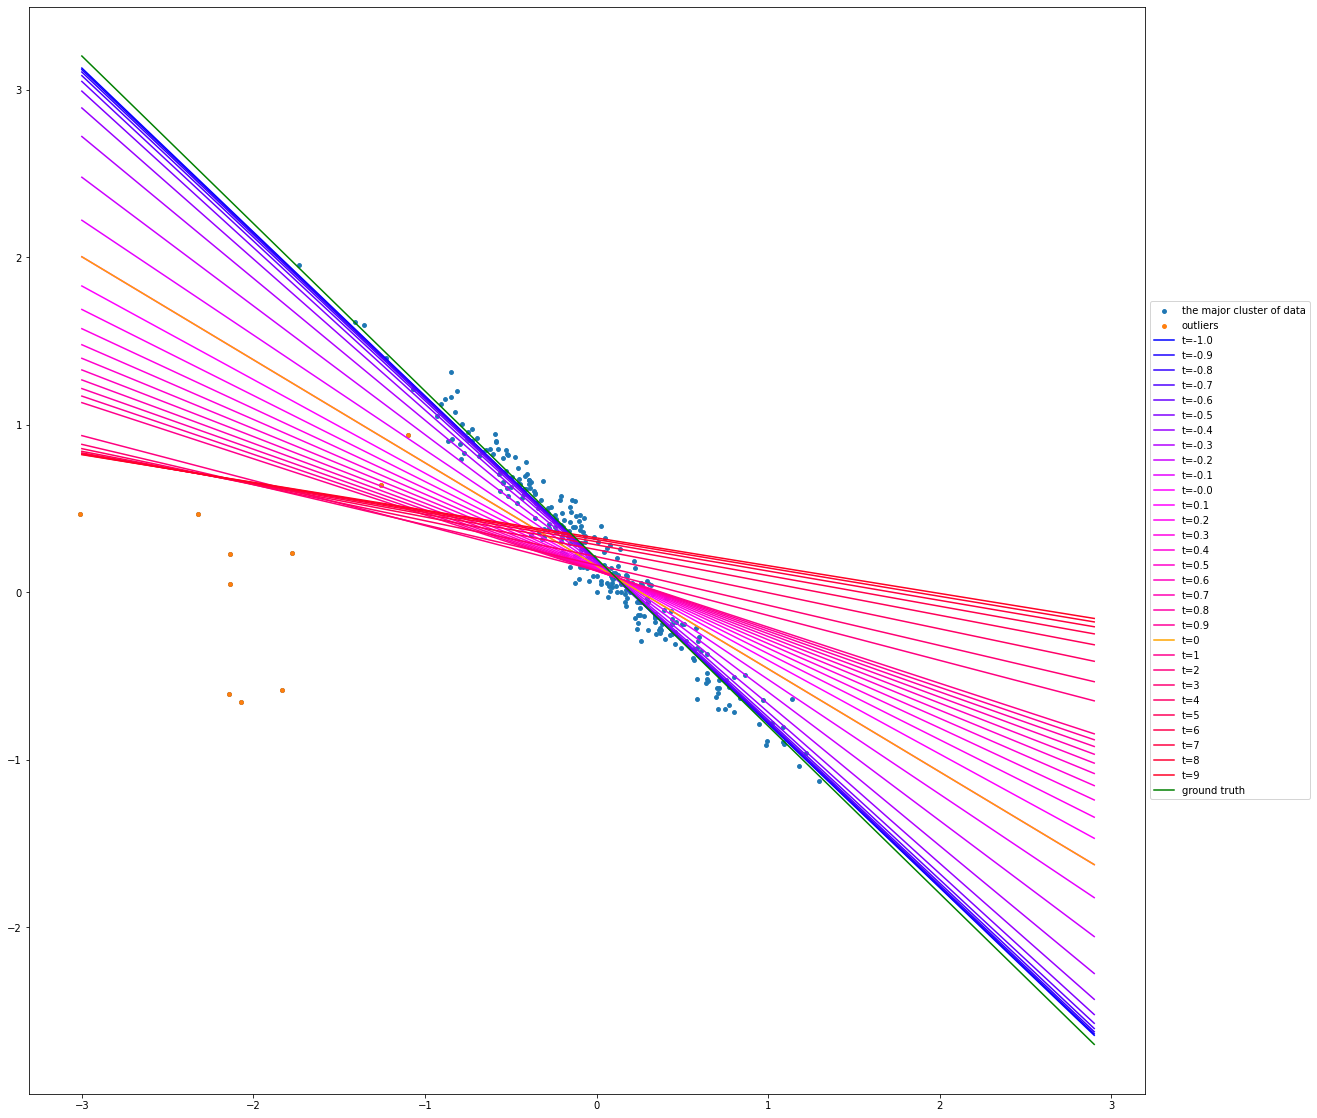

In [179]:
plt.figure(figsize=(20, 20))
plt.scatter(X, y, s=15, label='the major cluster of data')
plt.scatter(X_out, y_out, s=15, label="outliers")

blue = (0, 0, 1)
red = (1, 0, 1)

for i, t in enumerate(tilts):
    color = 'orange'
    if t < 0:
        color = blue
        blue = (blue[0] + 0.1, blue[1], blue[2])
    elif t > 0:
        color = red
        red = (red[0], red[1], red[2] - 0.05)
    abline(weights[i], biases[i], 't=' + str(round(t, 1)), color)
abline(theta[0], theta[1], 'ground truth', 'green')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Random Labels

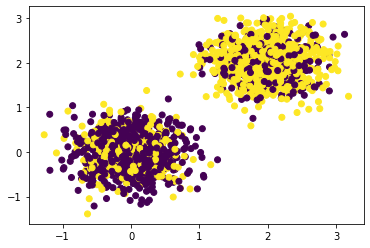

In [240]:
n_samples_1 = 1000
n_samples_2 = 1000
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Randomly flip a percentage of labels
percent = 0.3
n = len(y)
y_orig = np.array(list(y))
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y_orig = y_orig.reshape(-1, 1)
y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels_orig = torch.tensor(y_orig, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

0.6052588820457458
0.33714067935943604
0.3356475234031677
0.3351703882217407
0.3349331319332123
0.33478909730911255
0.33469170331954956
0.33462125062942505
0.3345678448677063
0.33452579379081726
Final loss:  0.3344918191432953


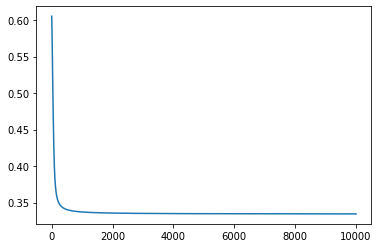

In [250]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

t = -1 
criterion = EntropicRisk(t=t)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

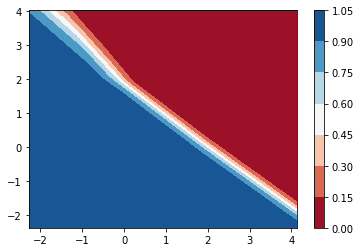

In [251]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

Num losses > 0.4: (1, 0)


(0.0, 2000.0)

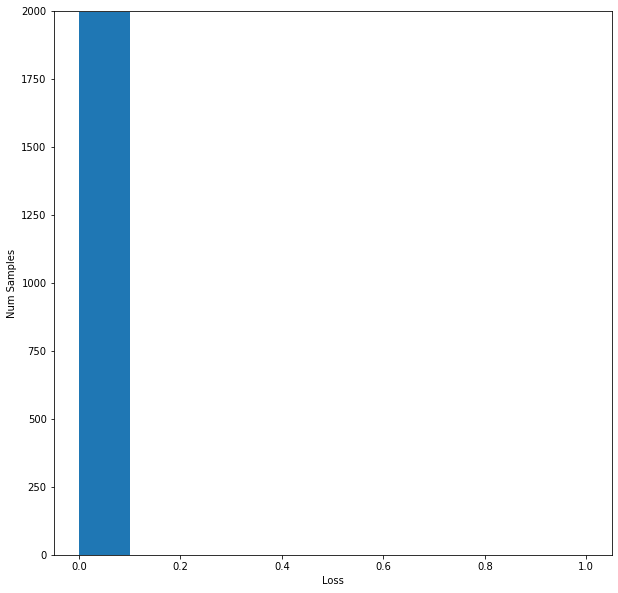

In [253]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    for i in range(len(inputs)):
        output = model(inputs[i])
        output = output[None, :]
        loss = criterion(output, labels_orig[i].type(torch.LongTensor))
        losses.append(loss.item())
        
print('Num losses > 0.4:', np.array(np.where(np.array(losses) > 0.4)).shape)

plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 2000))

## Class Imbalance

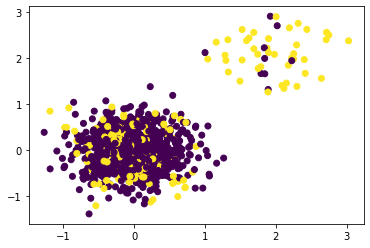

In [254]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Randomly flip a percentage of labels
percent = 0.2
n = len(y)
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

0.7600354552268982
0.2144264578819275
0.2125733494758606
0.21210834383964539
0.211896151304245
0.211774080991745
0.2116943895816803
0.21163973212242126
0.2115994393825531
0.21156814694404602
Final loss:  0.21154287457466125


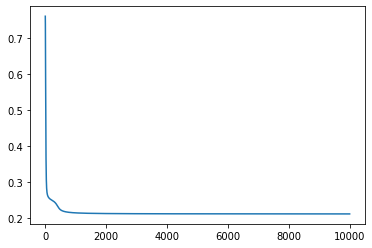

In [255]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

t = -1
criterion = EntropicRisk(t=t)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

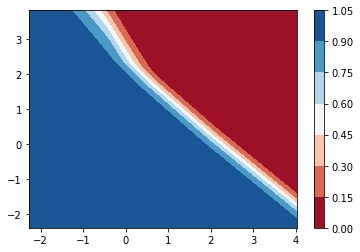

In [256]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

Num losses > 0.4: (1, 200)


(0.0, 1050.0)

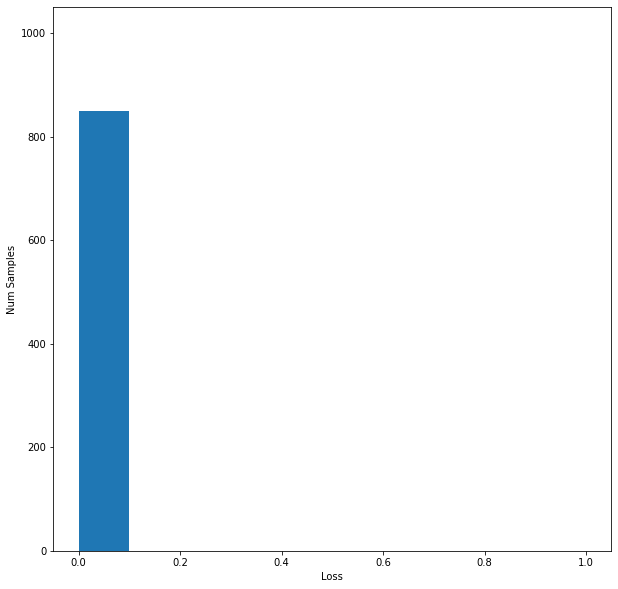

In [257]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    for i in range(len(inputs)):
        output = model(inputs[i])
        output = output[None, :]
        loss = criterion(output, labels[i].type(torch.LongTensor))
        losses.append(loss.item())
        
print('Num losses > 0.4:', np.array(np.where(np.array(losses) > 0.4)).shape)

plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1.0])
plt.ylim((None, 1050))

## Fair Regression

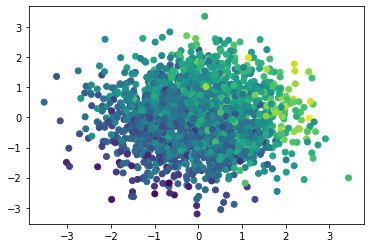

In [23]:
num_train = 2000
num_test = 20000
total_points = num_train + num_test
DATA_DIM = 5

X = np.random.normal(loc=0, scale=1, size=(total_points, DATA_DIM))

X_train = X[:num_train]
eps_train = np.random.normal(loc=0, scale=0.01, size=(num_train, 1))

theta = np.array([1 for _ in range(DATA_DIM)])
y_train = np.array([X_train[i].dot(theta) + eps_train[i] if X_train[i][0] <= 1.645 else X_train[i].dot(theta) + X_train[i][0] + eps_train[i] for i in range(num_train)])

plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

y_train = y_train.reshape(-1, 1)
inputs = torch.tensor(X_train, dtype=torch.float)
labels = torch.tensor(y_train, dtype=torch.float)

In [24]:
X_test = X[num_train:]
eps_test = np.random.normal(loc=0, scale=0.01, size=(num_test, 1))

theta = np.array([1 for _ in range(DATA_DIM)])
is_majority = [False if X_test[i][0] > 1.645 else True for i in range(num_test)]
y_test = np.array([X_test[i].dot(theta) + eps_test[i] if X_test[i][0] <= 1.645 else X_test[i].dot(theta) + X_test[i][0] + eps_test[i] for i in range(num_test)])
y_test = y_test.reshape(-1, 1)

In [25]:
input_size = DATA_DIM
h1 = 50
h2 = 25
epochs = 200

class RegressionMLP(nn.Module):
    def __init__(self, input_size, h1, h2):
        super(RegressionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## ERM

5.213334083557129
Final training loss:  0.058047015219926834
Majority Risk: 0.046845693141222
Minority Risk: 0.46406421065330505


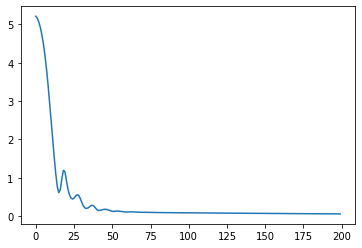

In [27]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = nn.MSELoss(reduction='mean')

model = RegressionMLP(input_size, h1, h2)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.type(torch.float32))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final training loss: ", losses[-1])
plt.plot(losses)

model.eval()
majority_losses = []
minority_losses = []

with torch.no_grad():
    for i, sample in enumerate(list(zip(X_test, y_test))):
        X, y = sample
        output = model(torch.tensor(X, dtype=torch.float32))

        loss = criterion(output, torch.tensor(y, dtype=torch.float32))
        if is_majority[i]:
            majority_losses.append(loss)
        else:
            minority_losses.append(loss)
            
erm_majority_risk = torch.mean(torch.tensor(majority_losses)).item()
erm_minority_risk = torch.mean(torch.tensor(minority_losses)).item()
print('Majority Risk:', erm_majority_risk)
print('Minority Risk:', erm_minority_risk)

## Entropic Risk

Final training loss for t=-0.15: 0.06605659425258636
Majority Risk For t=-0.15: 0.05172616243362427
Minority Risk For t=-0.15: 0.558118462562561
Final training loss for t=-0.13999999999999999: 0.06565389782190323
Majority Risk For t=-0.13999999999999999: 0.051387719810009
Minority Risk For t=-0.13999999999999999: 0.5492584705352783
Final training loss for t=-0.12999999999999998: 0.06526070088148117
Majority Risk For t=-0.12999999999999998: 0.051189836114645004
Minority Risk For t=-0.12999999999999998: 0.5433412790298462
Final training loss for t=-0.11999999999999997: 0.06480414420366287
Majority Risk For t=-0.11999999999999997: 0.05092712119221687
Minority Risk For t=-0.11999999999999997: 0.5390371680259705
Final training loss for t=-0.10999999999999996: 0.06445138901472092
Majority Risk For t=-0.10999999999999996: 0.05077901855111122
Minority Risk For t=-0.10999999999999996: 0.5341380834579468
Final training loss for t=-0.09999999999999995: 0.0639716163277626
Majority Risk For t=-0.09

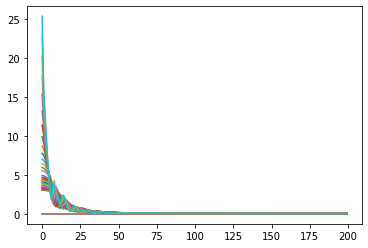

In [30]:
tilts = [i for i in np.arange(-0.15, 0.15, 0.01)]

majority_risks = []
minority_risks = []

for t in tilts:
    # Reset random seeds for comparaison.
    SEED = 15
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

    criterion = EntropicRisk(t=t, criterion=nn.MSELoss(reduction='none'))

    model = RegressionMLP(input_size, h1, h2)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    losses = []

    for epoch in range(epochs):
        # clear the gradients so they wont accumulate
        optimizer.zero_grad()

        output = model(inputs)
        # negative likelihood (expected risk)
        loss = criterion(output.squeeze(1), labels.squeeze(1).type(torch.float32))
        losses.append(loss.item())

        # calculate gradient
        loss.backward()

        # gradient descent
        optimizer.step()

    print("Final training loss for t={}: {}".format(t, losses[-1]))
    plt.plot(losses)

    model.eval()
    majority_losses = []
    minority_losses = []
    
    criterion = nn.MSELoss(reduction='mean')

    with torch.no_grad():
        for i, sample in enumerate(list(zip(X_test, y_test))):
            X, y = sample
            output = model(torch.tensor(X, dtype=torch.float32))
            # negative likelihood (expected risk)
            loss = criterion(output, torch.tensor(y, dtype=torch.float32))
            if is_majority[i]:
                majority_losses.append(loss)
            else:
                minority_losses.append(loss)

    majority_risks.append(torch.mean(torch.tensor(majority_losses)).item())
    minority_risks.append(torch.mean(torch.tensor(minority_losses)).item())
    
    print('Majority Risk For t={}: {}'.format(t, majority_risks[-1]))
    print('Minority Risk For t={}: {}'.format(t, minority_risks[-1]))

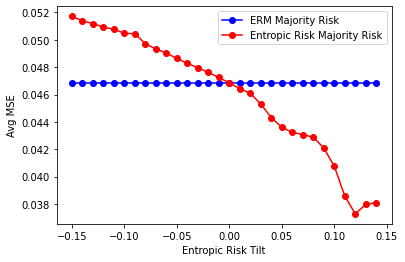

In [31]:
plt.plot(tilts, [erm_majority_risk for _ in range(len(majority_risks))], marker='o', color='b', label='ERM Majority Risk')
plt.plot(tilts, majority_risks, marker='o', color='r', label='Entropic Risk Majority Risk')
plt.xlabel('Entropic Risk Tilt')
plt.ylabel('Avg MSE')
plt.legend()

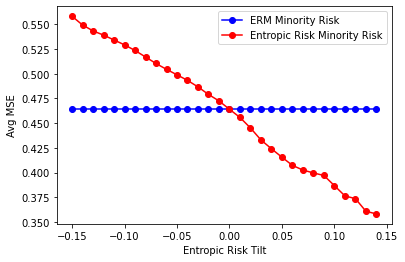

In [32]:
plt.plot(tilts, [erm_minority_risk for _ in range(len(minority_risks))], marker='o', color='b', label='ERM Minority Risk')
plt.plot(tilts, minority_risks, marker='o', color='r', label='Entropic Risk Minority Risk')
plt.xlabel('Entropic Risk Tilt')
plt.ylabel('Avg MSE')
plt.legend()

## XOR Classification

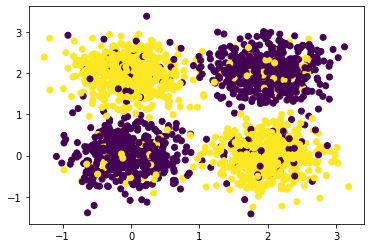

In [9]:
n_samples_1 = 500
n_samples_2 = 500
n_samples_3 = 500
n_samples_4 = 500
centers = [[0.0, 0.0], [0.0, 2.0], [2.0, 2.0], [2.0, 0.0]]
clusters_std = [0.4, 0.4, 0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2, n_samples_3, n_samples_4],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Set diagnoals to be the same class
y = y % 2

# Randomly flip a percentage of labels
percent = 0.1
n = len(y)
y_orig = np.array(list(y))
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y_orig = y_orig.reshape(-1, 1)
y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels_orig = torch.tensor(y_orig, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

## TERM

0.6991028785705566
0.14710229635238647
0.1273193508386612
0.12123763561248779
0.1181742399930954
0.11627394706010818
0.1149548888206482
0.11396636068820953
0.11318991333246231
0.11256181448698044
Final loss:  0.11203797906637192


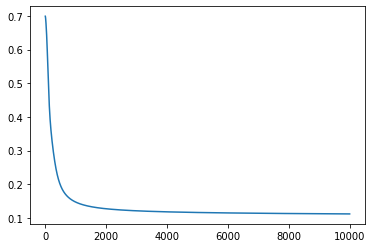

In [14]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = EntropicRisk(t=-1)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

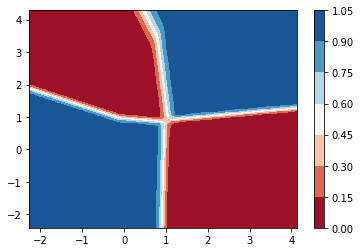

In [15]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)